# <span style='color:Blue'> CHECK YOUR BIAS:   </span>
## <span style='color:Blue'> A PYTHON TOOLKIT FOR FAIR LENDING  </span>

#### #### Summary: This toolkit explores small subset of ideas and techniques of auditing gender bias in credit assessment processes. For a comprehensive discussion of gender bias and fairness in credit assessment, see Women’s World Banking’s “Algorithmic Bias, Financial Inclusion, and Gender,” or our most recent publication, “Check Your Bias! A Field Guide for Lenders,” both available on the Women’s World Banking website. Questions or comments on this toolkit? Email Women’s World Banking at info@womensworldbanking.org.

######  Learning objectives:
###### • Increase awareness about different types of gender bias that may manifest in credit assessment processes
###### • Explore and detect gender biases and their sources in credit assessment processes

## <span style='color:Green'> Part III  - Rejected applicants</span>
### <span style='color:Green'> Using inferential statistics to audit for gender bias in credit processes 

Matching methods are a non-parametric approach that involve taking observational data, and matching people who have similar characteristics but different treatments, as a way of conducting 
causal inference or other estimations. The intuitiveness of the approach, in additional to a few 
other advantageous statistical properties, make it a useful method for reject inference as well.
There are many potential matching strategies to 
choose from, and each has its relative merits. For our purposes, we apply a recently developed 
method called coarsened exact matching. In our application of this technique, we start by identifying 
the approved and rejected applicants in the sample (i.e. we tag these as separate cohorts, but keep the sample intact). We then apply the coarsened exact matching algorithm, which divides the full sample into meaningful strata based on relevant variables of interest. The user must select these variables, taking into consideration the ones that are likely to be strong predictors of loan performance issues and also have data that is generally available (i.e., tends to be complete for all applicants). In practice, any categorical variables are subjected to exact matching and any continuous variables are split into bins.6 For each stratum, the coarsened exact matching process then identifies any matches between the approved and rejected cohorts. For our purposes, we use only strata that have 
matched approved and rejected applications. All non-matched observations/strata are ignored. For 
each stratum, where matches are found, we use the observed loan performance of the matched approved applications in a given stratum to impute predicted loan performance among the matched rejected applications. For example, we construct a variable, which we call “any NPL imputed” and set it to 1 for a given matched rejected application if the matched approved application in their strata had an NPL and set it to 0 if they did not. In the simplest scenario, if there is only one matched approved/disbursed application in the stratum, then its loan performance is used to impute the 
matched rejected applications’ performance. In the more common scenario where there are multiple 
approved/disbursed loans in the stratum, we use the mean loan performance. We set a loosely riskaverse threshold: If the actual probability of having an NPL is greater than or equal to 50% among the approved applications in the stratum, then we set “any NPL imputed” equal to 1 for the matched rejected applications and 0 otherwise. (Note that the threshold can be adjusted based on the risk tolerance of the lender.) Under this setup, we define: 
a. “False negatives” – rejected applicants
where “any NPL imputed” = 0
b. “True negatives” – rejected applicants where 
“any NPL imputed” = 1
We then combine the accepted and rejected applications into a single data set and do basic descriptive statistics on them. The outputs of this model would be similar to what we showed in following tables.

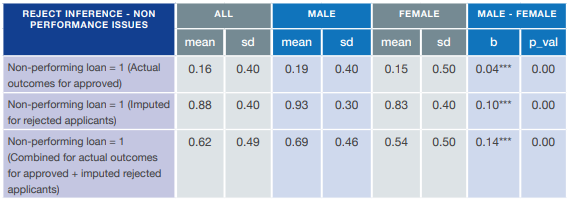

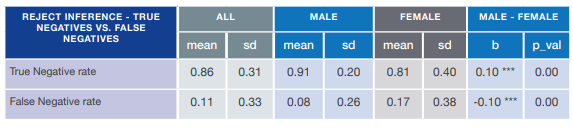


##### <span style='color:red'> Code 0:  </span>


Import packages

In [184]:
import os 
import emoji
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt                               # used for data visualization
import seaborn as sns                                         # used for data visualization
from sklearn.linear_model import LogisticRegression           # used for data audit bias
from sklearn.preprocessing import StandardScaler              # used in distance-based matching 
from sklearn.neighbors import NearestNeighbors                # used in distance-based matching  
from scipy.stats import ttest_ind, ttest_ind_from_stats       # used for data audit bias - balance tests
import patsy                                                  # a Python package for describing statistical models (especially linear models, or models that have a linear component) and building design matrices.
import statsmodels.api as sm                                  # used in modeling
import statsmodels.formula.api as smf                         # used in modeling
from IPython.display import HTML                              # used in print statement
from termcolor import colored                                 # used in print statement
from colorama import Fore, Back, Style                        # used in print statement
from termcolor import colored                                 # used in print statement

Set directory and import the data

In [ ]:
os.getcwd()
os.chdir('C:\\Users\mm\Downloads')

os.chdir('C:\\Users\mm\Downloads')       # set up the directory
os.getcwd()                              # check your assigned directory to make sure it works properly. 

df = pd.read_excel('df_dummy.xlsx')  # import dataset - The code that creates this data as 
                                         # well as the data itself in Excelsheet format is stored 
                                         # on the project GitHub page.

Recoding_the_Labels = {"Credit_Decision": {"Yes": 1, "No": 0}}
df.replace(Recoding_the_Labels, inplace = True)

# create separate datasets for approved and rejected applicants. The approved applicants dataset plays the same
# role that a treatment group has in a causal inference study. The rejected applicants dataset plays the same role that
# a control group plays in the same causal inference study.
# in the next steps, we use these two datasets. 
df_approved = df.loc[df['Credit_Decision'] == 1]
df_rejected = df.loc[df['Credit_Decision'] == 0]

df_all = pd.concat([df_approved, df_rejected])

In [ ]:
df_all_subset = df_all[['Age', 'Credit_Decision', 'Total_Income', 'Credit_Score']]

***

### Method 1. Auditing fairness among rejected applicants using matching algorithms

##### <span style='color:red'> Code 1:  </span>


* a. Compute propensity scores to start. 
* b. Separate the treated and controls again (preserve original indexing) in order to match them.

Note, this section might need some fine-tuning to make it match Dehejia and Wahba.

In [ ]:
propensity = LogisticRegression()

X = df_all_subset.drop(['Credit_Decision'], axis = 1)
y = df_all_subset.Credit_Decision

propensity = propensity.fit(X, y)

pscore = propensity.predict_proba(X)[:,1]   # The predicted propensities by the model

df_all_subset['Propensity'] = pscore

***

In [183]:
def Match(df, groups, propensity, ID, caliper):
    
    ''' 
    Inputs:
    groups = We have two groups of approved and rejected applicants. 
    propensity = Propensity scores for each observation.
    Propensity and groups should be in the same order (matching indices)
    caliper = Maximum difference in matched propensity scores. 
    We calculate the caliper based on Austin's reccommendation to use the logit of propensity.    
    
    Output:
    A series containing the rejected applicants matched to the approved applicants.
    Note that when we use caliper matching, not every approved applicants may have a match in the pool of rejected applicants.
    
    '''
# Check inputs
    if any(propensity <= 0) or any(propensity >= 1):
        raise ValueError('Propensity scores must be between 0 and 1')
    elif not(0 < caliper < 1):
        raise ValueError('Caliper must be between 0 and 1')
    elif len(groups)!= len(propensity):
        raise ValueError('groups and propensity scores must be same dimension')
    elif len(groups.unique()) != 2:
        raise ValueError('wrong number of groups')
          
    df_Approved = df.loc[df['Credit_Decision'] == 1]
    df_Approved.reset_index(inplace = True, drop = 'index')
    
    df_Rejected = df.loc[df['Credit_Decision'] == 0]
    df_Rejected.reset_index(inplace = True, drop = 'index')
    
    morder = np.random.permutation(df_Approved.index)
    
    Approved_Matched_ID = []; Rejected_Matched_ID = []
    
    counter = 1
   
    for m in morder:  
        dist = abs(df_Approved.Propensity[m] - df_Rejected.Propensity)   
        counter += 1
        Approved_Matched_ID.append(df_Approved.ID[m])
        Rejected_Matched_ID.append(df_Rejected.ID[dist.argmin()])     
    
        df_Rejected = df_Rejected.drop(df_Rejected.index[dist.argmin()])
        df_Rejected.reset_index(inplace = True, drop = 'index')
        
    df_output = pd.DataFrame(list(zip(Approved_Matched_ID, Rejected_Matched_ID)), columns = ['ID approved', 'ID rejected'])
    return df_output

##### <span style='color:orange'> Example 1:  </span>

In [ ]:
Matched_IDs = Match(df, df.Credit_Decision, df.Propensity, df.ID, 0.5)
Matched_IDs

### Method 2. Auditing fairness among rejected applicants using KNN - Matching based on distance

##### <span style='color:red'> Code 2:  </span>


In [185]:
def get_matching_pairs(treated_df, non_treated_df, scaler=True):

    treated_x = treated_df.values
    non_treated_x = non_treated_df.values

    if scaler == True:
        scaler = StandardScaler()

    if scaler:
        scaler.fit(treated_x)
        treated_x = scaler.transform(treated_x)
        non_treated_x = scaler.transform(non_treated_x)

    nbrs = NearestNeighbors(n_neighbors = 1, algorithm='ball_tree').fit(non_treated_x)
    distances, indices = nbrs.kneighbors(treated_x)
    indices = indices.reshape(indices.shape[0])
    matched = non_treated_df.iloc[indices]
    return matched

##### <span style='color:orange'> Example 2:  </span>

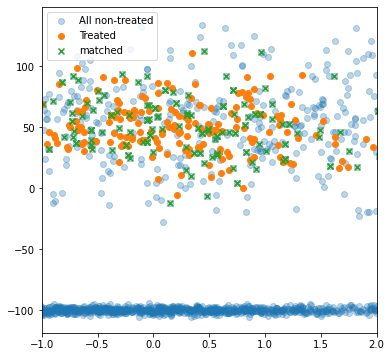

In [189]:
treated_df = pd.DataFrame()
np.random.seed(1)

size_1 = 200
size_2 = 1000
treated_df['x'] = np.random.normal(0,1,size = size_1)
treated_df['y'] = np.random.normal(50,20,size = size_1)
treated_df['z'] = np.random.normal(0,100,size = size_1)

non_treated_df = pd.DataFrame()
# two different populations
non_treated_df['x'] = list(np.random.normal(0, 3, size = size_2)) + list(np.random.normal(-1, 2, size = 2 * size_2))
non_treated_df['y'] = list(np.random.normal(50, 30, size = size_2)) + list(np.random.normal(-100, 2, size = 2 * size_2))
non_treated_df['z'] = list(np.random.normal(0, 200, size = size_2)) + list(np.random.normal(13, 200, size = 2 * size_2))

matched_df = get_matching_pairs(treated_df, non_treated_df)

fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(non_treated_df['x'], non_treated_df['y'], alpha = 0.3, label = 'All non-treated')
plt.scatter(treated_df['x'], treated_df['y'], label = 'Treated')
plt.scatter(matched_df['x'], matched_df['y'], marker = 'x', label = 'matched')
plt.legend()
plt.xlim(-1, 2)
plt.show()

***

### The End!

***

References:

* Rajeev Dehejia and Sadek Wahba, "Causal Effects in Non-Experimental Studies: Reevaluating the Evaluation of Training Programs," Journal of the American Statistical Association, Vol. 94, No. 448 (December 1999), pp. 1053-1062.
* Rajeev Dehejia and Sadek Wahba, "Propensity Score Matching Methods for Non-Experimental Causal Studies," Review of Economics and Statistics, Vol. 84, (February 2002), pp. 151-161.
* Robert Lalonde, "Evaluating the Econometric Evaluations of Training Programs," American Economic Review, Vol. 76 (1986), pp. 604-620.